In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

with tf.Session(config=run_config) as sess:
  dcgan = DCGAN(
      sess,
      input_width=FLAGS.input_width,
      input_height=FLAGS.input_height,
      output_width=FLAGS.output_width,
      output_height=FLAGS.output_height,
      batch_size=FLAGS.batch_size,
      sample_num=FLAGS.batch_size,
      dataset_name=FLAGS.dataset,
      input_fname_pattern=FLAGS.input_fname_pattern,
      crop=FLAGS.crop,
      checkpoint_dir=FLAGS.checkpoint_dir,
      sample_dir=FLAGS.sample_dir)

show_all_variables()

if not dcgan.load(FLAGS.checkpoint_dir)[0]:
  raise Exception("[!] Train a model first, then run test mode")
      

#OPTION = 0
#visualize(sess, dcgan, FLAGS, OPTION)


{}
---------
Variables: name (type shape) [size]
---------
generator/g_h0_lin/Matrix:0 (float32_ref 100x8192) [819200, bytes: 3276800]
generator/g_h0_lin/bias:0 (float32_ref 8192) [8192, bytes: 32768]
generator/g_bn0/beta:0 (float32_ref 512) [512, bytes: 2048]
generator/g_bn0/gamma:0 (float32_ref 512) [512, bytes: 2048]
generator/g_h1/w:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
generator/g_h1/biases:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/beta:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/gamma:0 (float32_ref 256) [256, bytes: 1024]
generator/g_h2/w:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
generator/g_h2/biases:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/beta:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/gamma:0 (float32_ref 128) [128, bytes: 512]
generator/g_h3/w:0 (float32_ref 5x5x64x128) [204800, bytes: 819200]
generator/g_h3/biases:0 (float32_ref 64) [64, bytes: 256]
generator/g_bn3/beta:0 (float32_ref 64) [64, byte

In [2]:
from glob import glob
from ops import *
from utils import *

data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file, input_height=dcgan.input_height,
                    input_width=dcgan.input_width,
                    resize_height=dcgan.output_height,
                    resize_width=dcgan.output_width,
                    crop=dcgan.crop,
                    grayscale=dcgan.grayscale) for sample_file in sample_files]

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

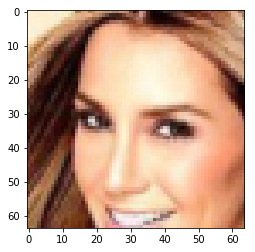

In [4]:
plt.imshow((sample[0] + 1)/2)

In [5]:
v = np.reshape(sample, (64, 64*64*3))
n = v.shape[1]
print(n)

12288


In [6]:
m = 1000
A = np.random.randn(n, m).astype('float32')

In [7]:
y = np.dot(v, A) 

In [8]:

y_placeholder = tf.placeholder(tf.float32,[None,m])

our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2 ) ) #need to change from vector to matrix for 64 

In [ ]:
#z_optim = tf.train.AdamOptimizer(0.0002, 0.5).minimize(our_loss, var_list=dcgan.z)
    
grad = tf.gradients(our_loss, dcgan.z)

z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))

prev2 = 9999999999
prev1 = 999999999

rate = 0.0002
count = 0

errs = []
    
with tf.Session() as sess:
    try:
      tf.global_variables_initializer().run()
    except:
      tf.initialize_all_variables().run()
    
    while prev1 < prev2 or rate > 0.0000000002: # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([grad, our_loss, dcgan.G],
            feed_dict={ 
              dcgan.z: z_0,
              y_placeholder: y
            })
        count += 1
        prev2, prev1 = prev1, closs
        if count % 100 == 0:
            rate /= 2
        print(closs)
        errs.append(closs)
        z_0 = z_0 - rate*a[0]
    

iteration 0
2.48703e+08
iteration 1
2.37899e+08
iteration 2
2.35379e+08
iteration 3
2.33108e+08
iteration 4
2.31046e+08
iteration 5
2.29166e+08
iteration 6
2.27455e+08
iteration 7
2.25911e+08
iteration 8
2.245e+08
iteration 9
2.23171e+08
iteration 10
2.21932e+08
iteration 11
2.20754e+08
iteration 12
2.19659e+08
iteration 13
2.18636e+08
iteration 14
2.17685e+08
iteration 15
2.16801e+08
iteration 16
2.15969e+08
iteration 17
2.15186e+08
iteration 18
2.1445e+08
iteration 19
2.13755e+08
iteration 20
2.13105e+08
iteration 21
2.12491e+08
iteration 22
2.11902e+08
iteration 23
2.1135e+08
iteration 24
2.10837e+08
iteration 25
2.10345e+08
iteration 26
2.09876e+08
iteration 27
2.0943e+08
iteration 28
2.09006e+08
iteration 29
2.08601e+08
iteration 30
2.08211e+08
iteration 31
2.07833e+08
iteration 32
2.07464e+08
iteration 33
2.07114e+08
iteration 34
2.06781e+08
iteration 35
2.06461e+08
iteration 36
2.06151e+08
iteration 37
2.05852e+08
iteration 38
2.05557e+08
iteration 39
2.05272e+08
iteration 40
2.

1.93053e+08
iteration 322
1.93048e+08
iteration 323
1.93043e+08
iteration 324
1.93038e+08
iteration 325
1.93033e+08
iteration 326
1.93028e+08
iteration 327
1.93023e+08
iteration 328
1.93017e+08
iteration 329
1.93012e+08
iteration 330
1.93007e+08
iteration 331
1.93002e+08
iteration 332
1.92997e+08
iteration 333
1.92992e+08
iteration 334
1.92987e+08
iteration 335
1.92981e+08
iteration 336
1.92976e+08
iteration 337
1.92971e+08
iteration 338
1.92966e+08
iteration 339
1.92961e+08
iteration 340
1.92955e+08
iteration 341
1.9295e+08
iteration 342
1.92945e+08
iteration 343
1.92939e+08
iteration 344
1.92933e+08
iteration 345
1.92929e+08
iteration 346
1.92923e+08
iteration 347
1.92918e+08
iteration 348
1.92913e+08
iteration 349
1.92907e+08
iteration 350
1.92902e+08
iteration 351
1.92896e+08
iteration 352
1.92891e+08
iteration 353
1.92886e+08
iteration 354
1.92881e+08
iteration 355
1.92876e+08
iteration 356
1.9287e+08
iteration 357
1.92865e+08
iteration 358
1.9286e+08
iteration 359
1.92855e+08
ite

1.92265e+08
iteration 639
1.92264e+08
iteration 640
1.92264e+08
iteration 641
1.92263e+08
iteration 642
1.92262e+08
iteration 643
1.92262e+08
iteration 644
1.92261e+08
iteration 645
1.9226e+08
iteration 646
1.9226e+08
iteration 647
1.92259e+08
iteration 648
1.92259e+08
iteration 649
1.92258e+08
iteration 650
1.92258e+08
iteration 651
1.92257e+08
iteration 652
1.92256e+08
iteration 653
1.92256e+08
iteration 654
1.92255e+08
iteration 655
1.92255e+08
iteration 656
1.92254e+08
iteration 657
1.92254e+08
iteration 658
1.92253e+08
iteration 659
1.92253e+08
iteration 660
1.92252e+08
iteration 661
1.92251e+08
iteration 662
1.92251e+08
iteration 663
1.9225e+08
iteration 664
1.92249e+08
iteration 665
1.92249e+08
iteration 666
1.92248e+08
iteration 667
1.92248e+08
iteration 668
1.92247e+08
iteration 669
1.92247e+08
iteration 670
1.92246e+08
iteration 671
1.92245e+08
iteration 672
1.92245e+08
iteration 673
1.92244e+08
iteration 674
1.92244e+08
iteration 675
1.92243e+08
iteration 676
1.92243e+08
ite

1.92183e+08
iteration 956
1.92183e+08
iteration 957
1.92183e+08
iteration 958
1.92183e+08
iteration 959
1.92183e+08
iteration 960
1.92183e+08
iteration 961
1.92183e+08
iteration 962
1.92183e+08
iteration 963
1.92182e+08
iteration 964
1.92182e+08
iteration 965
1.92182e+08
iteration 966
1.92182e+08
iteration 967
1.92182e+08
iteration 968
1.92182e+08
iteration 969
1.92182e+08
iteration 970
1.92182e+08
iteration 971
1.92182e+08
iteration 972
1.92182e+08
iteration 973
1.92182e+08
iteration 974
1.92182e+08
iteration 975
1.92182e+08
iteration 976
1.92182e+08
iteration 977
1.92181e+08
iteration 978
1.92181e+08
iteration 979
1.92181e+08
iteration 980
1.92181e+08
iteration 981
1.92181e+08
iteration 982
1.92181e+08
iteration 983
1.92181e+08
iteration 984
1.92181e+08
iteration 985
1.92181e+08
iteration 986
1.92181e+08
iteration 987
1.92181e+08
iteration 988
1.92181e+08
iteration 989
1.92181e+08
iteration 990
1.92181e+08
iteration 991
1.92181e+08
iteration 992
1.9218e+08
iteration 993
1.9218e+08
it

1.92174e+08
iteration 1262
1.92174e+08
iteration 1263
1.92174e+08
iteration 1264
1.92174e+08
iteration 1265
1.92174e+08
iteration 1266
1.92174e+08
iteration 1267
1.92174e+08
iteration 1268
1.92174e+08
iteration 1269
1.92174e+08
iteration 1270
1.92174e+08
iteration 1271
1.92174e+08
iteration 1272
1.92174e+08
iteration 1273
1.92174e+08
iteration 1274
1.92174e+08
iteration 1275
1.92174e+08
iteration 1276
1.92174e+08
iteration 1277
1.92174e+08
iteration 1278
1.92174e+08
iteration 1279
1.92174e+08
iteration 1280
1.92174e+08
iteration 1281
1.92174e+08
iteration 1282
1.92174e+08
iteration 1283
1.92174e+08
iteration 1284
1.92174e+08
iteration 1285
1.92174e+08
iteration 1286
1.92174e+08
iteration 1287
1.92174e+08
iteration 1288
1.92174e+08
iteration 1289
1.92174e+08
iteration 1290
1.92174e+08
iteration 1291
1.92174e+08
iteration 1292
1.92174e+08
iteration 1293
1.92174e+08
iteration 1294
1.92174e+08
iteration 1295
1.92174e+08
iteration 1296
1.92174e+08
iteration 1297
1.92174e+08
iteration 1298
1

[ -2477.11230469    280.97924805 -11534.72753906   4536.99951172
  -2294.55273438  22701.046875    14355.41601562 -15493.83007812
 -11278.6640625   16141.70019531   3747.09179688   4874.39892578
  -8687.39648438   4242.33154297 -15958.41992188 -13241.55859375
  11198.96386719  -1929.80395508   -796.63891602   8358.67675781
  14158.328125    15158.82226562  -9255.11328125 -11830.45214844
    490.80712891  15872.32226562  -1127.60229492  18418.359375
  -4404.77001953   1286.24975586 -24929.71289062   6358.47509766
 -18425.35546875  -7748.91699219    145.94335938   9440.5703125
   6987.99804688  -9432.04296875   8959.36132812   4530.63476562
 -15128.5078125   -8237.27539062  -9299.02734375  19541.73828125
 -10077.94726562   8252.45898438  -4782.05371094  -8929.95605469
  11629.01953125   6230.64257812  20780.01953125  -9803.50390625
  -3133.66064453  -3407.10742188   4655.81347656  -2190.44018555
  -4783.796875   -10480.93261719   7334.46044922   5303.22851562
   9950.24511719  10946.9316

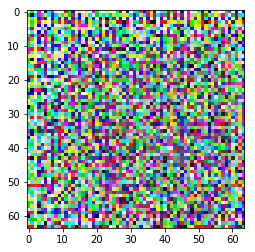

In [40]:
print(a[0][0])
print(a[0].shape)
plt.imshow(b[0])